# 13 프로젝트 : CIFAR-10 이미지 생성하기

- 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
- 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다.
- 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


## STEP 1. 데이터셋 구성하기
- 학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.
- 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

In [18]:
# 데이터셋 꺼내기 , load_data()로 로딩해보기  ( y_train, y_test에 해당하는 데이터 미사용)

cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [19]:
# Fashion MNIST  픽셀 살펴보기

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [20]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [21]:
# 색상에 대한 채널수 표기 추가 *1 흑백, 3 컬러

train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

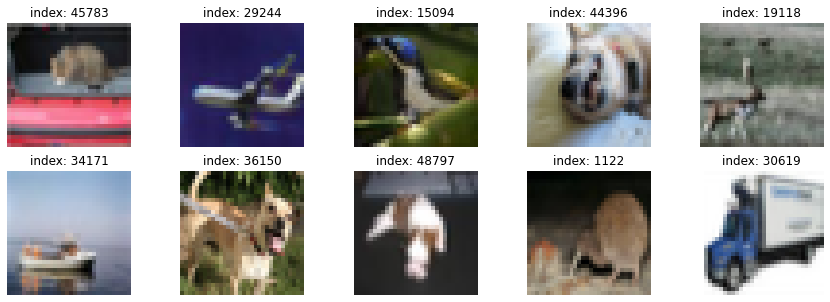

In [22]:
plt.figure(figsize=(15, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index] + 1)/2)
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

ValueError: cannot reshape array of size 3072 into shape (32,32)

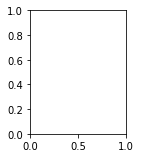

In [11]:
# 이미지 10개 확인

plt.figure(figsize=(10, 5)) #이미지 프레임의 크기  5는  이미지 크기로 확인됨.

for i in range(10):
    plt.subplot(2, 5, i+1) #10개의 이미지를 2x5의 배열 형태 배치, 0~9까지 반복을 위해 i+1
    plt.imshow(train_x[i].reshape(32, 32), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off') #함수로 불필요한 축을 지우기
plt.show()

In [ ]:
# 텐서 플로우 DATASET 준비

BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# 미니 배치 셔플

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## (1) GAN 이해하기
-  생성자(Generator): 아무 의미 없는 랜덤 노이즈로부터 신경망에서의 연산을 통해 이미지 형상의 벡터를 생성
- 판별자(Discriminator): 기존에 있던 진짜 이미지와 생성자가 만들어낸 이미지를 입력받아 각 이미지가 Real인지, Fake인지에 대한 판단 정도를 실숫값으로 출력

## (2) 생성자 구현하기

- DCGAN(Deep Convolutional GAN) 모델로 이전의 GAN을 더욱 발전시켜서 훨씬 그럴듯한 고화질 이미지 생성

In [ ]:
def make_generator_model():  #함수를 만들어서 언제든 생성자를 생성

    # Start
    model = tf.keras.Sequential()  # 레이어 단계별로 쌓아주기

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer  #  Convolutional 연산을 위해 1차원 벡터를 (7, 7, 256) 형상의 3차원 벡터로 변환시키는 작업
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer #이미지를 넓혀 주는 층
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer  
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model


In [ ]:
generator = make_generator_model()

generator.summary()

In [ ]:
#노이즈 벡터 생성

noise = tf.random.normal([1, 100]) 

In [ ]:
#이미지 생성 확인 

generated_image = generator(noise, training=False)  # 학습중이 아니므로 False 적용
generated_image.shape


In [ ]:
# 이미지 시각화 구현 ( -1과 1 사이의 값에서 적당히 잘 생성된 것을 확인)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

## (3) 판별자 구현하기

In [ ]:
def make_discriminator_model():   #함수를 만들어서 언제든 판별자를 생성

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1])) # 사이즈 축소
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer  # 3차원에서 1차원으로 변환
    model.add(layers.Flatten())

    # Fourth: Dense Layer  # 1차원으로 출력
    model.add(layers.Dense(1))

    return model

- <mark>판별자는 Convolutional 연산을 위해 이미지를 키워나갔던 Reshape layer 를 적용시키는 생성자와 달리 Conv2D 층으로 이미지의 크기를 점점 줄여나가기

In [ ]:
discriminator = make_discriminator_model()

discriminator.summary()

In [ ]:
#가짜 이미지 판별자 입력

decision = discriminator(generated_image, training=False)
decision

## (4) 손실함수와 최적화 함수
- GAN은 손실함수로 교차 엔트로피를 사용(점점 가까워지기 원하는 두 값이 얼마나 차이나는지 정량적으로 계산)
- 판별자는 2개 클래스 간 분류 문제를 풀어야 하므로 이진 교차엔트로피를 사용한다. 

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

1.  판별자 모델의 맨 마지막 Layer에는 값을 정규화시키는 sigmoid나 tanh 함수와 같은 활성화 함수가 없어 출력하는 값의 범위가 정해지지 않아 모든 실숫값을 가질수 있다. 
2. from_logits를 True로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산 할 수 있다.
- fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)
- real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)

In [ ]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)  # 특정 벡터와 동일한 크기이면서 값은 1 또는 0으로 가득 채워진 벡터를 만들고 싶을 때 사용

In [ ]:
# generator_loss(생성자로스)  *fake_output가 1에 가까워지기를 바람

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# discriminator_loss(판별자로스)  *real_output(1로 채워진 벡터) + fake_output(0으로 채워진 벡터 비교) 두가지 loss값 더하기

BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# discriminator accuracy 계산해 보기
def discriminator_accuracy(real_output, fake_output):
    #real_output 0.5 이상판별
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    # 위 결과가 true 1.0 이면 false 0.0 변환,  tf.reduce_mean 결과를 평균내어 해당 배치도 정확도 계산
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32)) 
    return real_accuracy, fake_accuracy

<mark> - 판별자의 두 아웃풋 accuracy가 1.0 인 경우 fake output이 real output과 차이가 많이 나서 판별자가 매우 쉽게 판별해 내고 있다는 뜻
<mark> - real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적이다.   

In [ ]:
# Adam 최적화 기법 *생성자와 구분자는 각각 학습을 진행하는 개별 네트워크 이므로 최적화도 따로 만들어줘야 한다. 

generator_optimizer = tf.keras.optimizers.Adam(1e-4) #생성자 최적화
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)  #판별자 최적화

In [ ]:
# 생성자 샘플확인을 위한 고정 seed 노이즈 만들기

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

## (5) 훈련과정 설계
- 텐서플로우 2.0 이후부터 학습시킬 훈련 함수 위에 @tf.function 이라는 데코레이터를 붙여서 사용

In [ ]:
# @tf.function 데코레이터가 적용 전
import numpy as np
import tensorflow as tf

def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

In [ ]:
# @tf.function 데코레이터가 적용 후  ->>향후 Tensorflow 모델 구현에 매우 편리하게 사용

import numpy as np
import tensorflow as tf

@tf.function    # 위와 동일한 함수이지만 @tf.function 데코레이터가 적용되었습니다.
def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

In [ ]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

[train_step]
- 입력데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
- 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
- tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
- generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
- discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
- loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
- accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산
- gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
- 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
- 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

In [ ]:
# 일정 간격의 학습현황 살펴보기

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
   
   try : 
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [ ]:
#  정기적으로 모델을 저장하기 위한 checkpoint 만들기

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

- tf.train.Checkpoint를 활용하면 매번 모델을 직접 저장해주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리

## (6) 훈련과정 학습

In [ ]:
# 모델 학습

def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [ ]:
# 학습현황 확인

save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

In [ ]:
# GAN 학습

%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [ ]:
# 학습과정 시각화

anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif